Linear Regression CV (neg MAE): -20.8888
Best Lasso alpha: 0.10 | CV Score: -19.3181


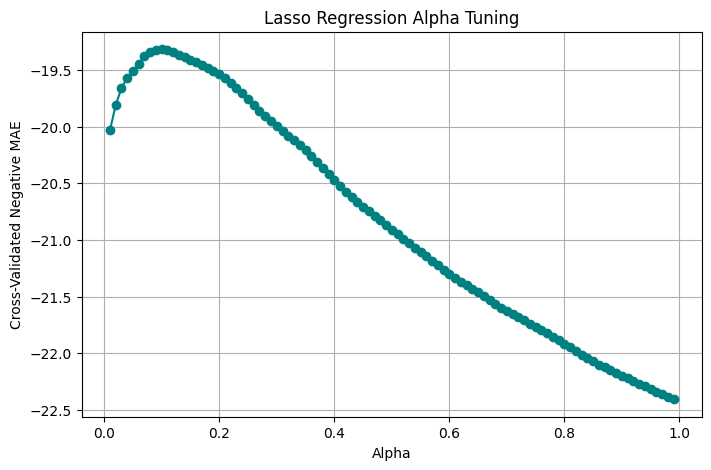

[-16.10863636 -15.99356061 -14.6578934 ]

Best Random Forest Params: {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 90}
Best Random Forest CV Score (neg MAE): -16.1199

Best Random Forest Estimator: RandomForestRegressor(max_features='sqrt', n_estimators=90, random_state=42)

--- Model Evaluation on Test Set ---
Linear Model MAE: 18.840500274827328
Lasso Model MAE: 19.648187965041064
Random Forest Model MAE: 12.80283370618941
14.63988279450136


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('eda_data.csv')

# choose relevant columns
df.columns

df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly','employer_provided',
             'job_state','same_state','age','python_yn','spark','aws','excel','job_simp','seniority','desc_len']]

# get dummy data (One-hot encode categorical columns)
df_dum = pd.get_dummies(df_model, drop_first=True)

#train test split

X= df_dum.drop('avg_salary', axis=1)
y= df_dum.avg_salary.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#linear regression

lm = LinearRegression()
lm.fit(X_train, y_train)
lm_cv = np.mean(cross_val_score(lm, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))
print(f"Linear Regression CV (neg MAE): {lm_cv:.4f}")

#lasso regression

alpha = []
error = []

for i in range(1, 100):
    a = i / 100
    lml = Lasso(alpha=a)
    cv_error = np.mean(cross_val_score(lml, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))
    alpha.append(a)
    error.append(cv_error)

# Df for alpha-error pairs
df_err = pd.DataFrame({'alpha': alpha, 'error': error})

# best alpha
best = df_err.loc[df_err['error'].idxmax()]
best_alpha = best['alpha']
print(f"Best Lasso alpha: {best_alpha:.2f} | CV Score: {best['error']:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(alpha, error, marker='o', color='teal')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validated Negative MAE')
plt.title('Lasso Regression Alpha Tuning')
plt.grid(True)
plt.show()

lm_l = Lasso(alpha=best_alpha)
lm_l.fit(X_train, y_train)

#random forest
rf = RandomForestRegressor(random_state=42)

print(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))

# tune using GridSearchCV
parameters = {'n_estimators':range(10,300,10), 'criterion':['squared_error'], 'max_features':['sqrt','log2']}

gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=3)
gs.fit(X_train,y_train)

print("\nBest Random Forest Params:", gs.best_params_)
print(f"Best Random Forest CV Score (neg MAE): {gs.best_score_:.4f}")
print("\nBest Random Forest Estimator:", gs.best_estimator_)


# test ensembles
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

print("\n--- Model Evaluation on Test Set ---")
print('Linear Model MAE:', mean_absolute_error(y_test, tpred_lm))
print('Lasso Model MAE:', mean_absolute_error(y_test, tpred_lml))
print('Random Forest Model MAE:', mean_absolute_error(y_test, tpred_rf))
print(mean_absolute_error(y_test, (tpred_lm+tpred_rf)/2))


import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump(pickl, open('model_file' + ".p", "wb"))

In [6]:
import pickle
pickl = {'model': gs.best_estimator_, 'columns': list(X.columns)}
pickle.dump(pickl, open('model_file' + ".p", "wb"))

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

sample = X_test.iloc[[1]]

prediction = model.predict(sample)[0]
print("Predicted value:", prediction)

Predicted value: 52.55555555555556
